In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import GlobalAveragePooling2D,Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adagrad
# 数据准备
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,# ((x/255)-0.5)*2  归一化到±1之间
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

Using TensorFlow backend.


这里用到的数据集和之前都不同，之前用的是一些公共的、Keras内置的数据集，这次用到的是自己准备的数据集。由于数据的图像大小比较大，不适合一次全部载入到内存中，所以使用了flow_from_directory方法来按批次从硬盘读取图像数据，并实时进行图像增强

In [2]:
# 資料路徑
DATASET_PATH  = r'C:\Users\user\程式碼_明昌瑕疵檢測\影像辨識\Machan Dataset'

# 影像大小
IMAGE_SIZE = (299,299)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 10



# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-Inception_V3-final.h5'



train_generator = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                  target_size=IMAGE_SIZE,#Inception V3规定大小
                                  batch_size=BATCH_SIZE)
val_generator = val_datagen.flow_from_directory(DATASET_PATH + '/validation',
                                  target_size=IMAGE_SIZE,
                                  batch_size=BATCH_SIZE)

Found 1920 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


首先我们需要加载骨架模型，这里用的InceptionV3模型，其两个参数比较重要，一个是weights，如果是'imagenet',Keras就会自动下载已经在ImageNet上训练好的参数，如果是None，系统会通过随机的方式初始化参数，目前该参数只有这两个选择。另一个参数是include_top，如果是True，输出是1000个节点的全连接层。如果是False，会去掉顶层，输出一个8 \* 8 \* 2048的张量。 

ps：在keras.applications里还有很多其他的预置模型，比如VGG，ResNet，以及适用于移动端的MobileNet等。大家都可以拿来玩玩。

一般我们做迁移训练，都是要去掉顶层，后面接上各种自定义的其它新层。这已经成为了训练新任务惯用的套路。
输出层先用GlobalAveragePooling2D函数将8 \* 8 \* 2048的输出转换成1 \* 2048的张量。后面接了一个1024个节点的全连接层，最后是一个17个节点的输出层，用softmax激活函数。

In [3]:
# 构建基础模型
base_model = InceptionV3(weights='imagenet',include_top=False)

# 增加新的输出层
x = base_model.output
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D 将 MxNxC 的张量转换成 1xC 张量，C是通道数
x = Dense(1024,activation='relu')(x)
predictions = Dense(2,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)
# plot_model(model,'tlmodel.png')

W0913 16:57:43.116146 18400 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 16:57:43.140067 18400 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 16:57:43.150724 18400 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 16:57:43.212095 18400 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0913 16:57:43.213126 18400 deprecation_wrapper.py:119] From

构建完新模型后需要进行模型的配置。下面的两个函数分别对transfer learning和fine tune两种方法分别进行了配置。每个函数有两个参数，分别是model和base_model。这里可能会有同学有疑问，上面定义了model，这里又将base_model一起做配置，对base_model的更改会对model产生影响么？  
答案是会的。如果你debug追进去看的话，可以看到model的第一层和base_model的第一层是指向同一个内存地址的。这里将base_model作为参数，只是为了方便对骨架模型进行设置。

setup_to_transfer_learning： 这个函数将骨架模型的所有层都设置为不可训练
setup_to_fine_tune：这个函数将骨架模型中的前几层设置为不可训练，后面的所有Inception模块都设置为可训练。  
这里面的GAP_LAYER需要配合打印图和调试的方法确认正确的值，感兴趣具体怎么操作的同学，可以私信我，以后看有没有必要把这个点写成教程。

In [4]:
'''
这里的base_model和model里面的iv3都指向同一个地址
'''
def setup_to_transfer_learning(model,base_model):#base_model
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

#def setup_to_fine_tune(model,base_model):
#    for layer in base_model.layers[:172]:
#        layer.trainable = False
#    for layer in base_model.layers[172:]:
#        layer.trainable = True
#    model.compile(optimizer=Adagrad(lr=0.00001),loss='binary_crossentropy',metrics=['accuracy'])

下面开始训练，这段代码也演示了如何在全部训练过程中改变模型。

In [5]:
setup_to_transfer_learning(model,base_model)
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=800,
                    epochs=BATCH_SIZE,
                    validation_data=val_generator,
                    validation_steps=12,
                    class_weight='auto'
                    )
model.save(WEIGHTS_FINAL)

#setup_to_fine_tune(model,base_model)
#history = model.fit_generator(generator = train_generator,
#                              steps_per_epoch = train_generator.samples // BATCH_SIZE,
#                              epochs = 10,
#                              validation_data = val_generator,
#                              validation_steps = val_generator.samples // BATCH_SIZE,
#                              class_weight='auto')
#model.save(WEIGHTS_FINAL)

W0913 16:58:10.577016 18400 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0913 16:58:10.809477 18400 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
800/800 [==============================] - 373s 466ms/step - loss: 0.2004 - acc: 0.9260 - val_loss: 0.3715 - val_acc: 0.8333
Epoch 2/10
800/800 [==============================] - 364s 455ms/step - loss: 0.1114 - acc: 0.9609 - val_loss: 0.2439 - val_acc: 0.9250
Epoch 3/10
800/800 [==============================] - 366s 457ms/step - loss: 0.1065 - acc: 0.9610 - val_loss: 0.4628 - val_acc: 0.8667
Epoch 4/10
800/800 [==============================] - 366s 457ms/step - loss: 0.0862 - acc: 0.9676 - val_loss: 0.7061 - val_acc: 0.8000
Epoch 5/10
800/800 [==============================] - 365s 456ms/step - loss: 0.1046 - acc: 0.9611 - val_loss: 0.4113 - val_acc: 0.8583
Epoch 6/10
800/800 [==============================] - 363s 453ms/step - loss: 0.0744 - acc: 0.9724 - val_loss: 0.1577 - val_acc: 0.9417
Epoch 7/10
800/800 [==============================] - 194s 243ms/step - loss: 0.0654 - acc: 0.9764 - val_loss: 0.3921 - val_acc: 0.8750
Epoch 8/10
800/800 [============================

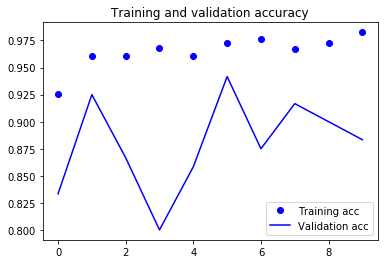

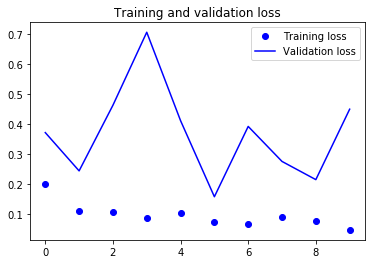

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

可以看到经过两个epoch的transfer learning后，验证集准确率达到89.1%。再经过两个epoch的fine tune后验证集准确率达96.88%。可以看到迁移学习的效果还是很好的。

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        DATASET_PATH + '/test',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=1)
print('test acc:', test_acc)

Found 640 images belonging to 2 classes.
test acc: 0.800000011920929


## 总结
1. 学习了两种常用迁移学习方法（tranfer learning,fine tune)及训练技巧
1. 学习了使用自己的数据样本进行训练
1. 学习了加载Keras预置的经典模型
1. 学习了如何在预置模型顶部添加新的层
1. 学习了如何设置层的参数为不可训练



### 参考
> https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2